<a href="https://colab.research.google.com/github/FranciscoBreia/Web-application-Design/blob/main/notebooks/colab/Timeline_Filter_and_render.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Timeline - Filter and render

*DTU - Explore the Energy Islands controversy*

**Goal**:
- Filter the visualization using a condition (a **query**)
- Render the visualization as a static image
- You have 4 variations to choose from

**How to use**:
- Edit settings if you want
- Then use "Runtime > Run all" or execute from the edited cell and below
- Wait for each cell to run
- ⚠️ Allow the script to access your Google Drive data when prompted to.
- **Edit the query** as you see fit
- Re-run that cell and the following ones to update the visualizations


## Settings

In [1]:
# SETTINGS (edit if necessary)
settings = {}
settings['year_first'] = 2016
settings['year_last'] = 2024
settings['plot_width']  = 12 # In cm
settings['plot_height'] =  6 # In cm

## Code

(You don't have to understand what's going on here, but feel free to take a look)

In [2]:
# Additional settings you shouldn't have to change
settings['statements_spreadsheet_drive_URL'] = 'https://docs.google.com/spreadsheets/d/1cSwVVXAB7kYRbGKEr6gc5IGs955dIfJNcCzyl_cywa8/edit?usp=drive_link'

### Install stuff
Note: already installed libraries will not be reinstalled, don't worry about re-running that.

In [3]:
!pip install pandas==2.2.2 gspread google-auth google-auth-oauthlib google-auth-httplib2

In [4]:
# Import necessary libraries
import pandas as pd
import json
import matplotlib.pyplot as plt

from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

### Load data from the corpus

In [5]:
# Open the spreadsheet by its key or URL
spreadsheet_key = settings['statements_spreadsheet_drive_URL'].split('/d/')[1].split('/edit')[0]
sh = gc.open_by_key(spreadsheet_key)

# Select the worksheet
worksheet_name = 'dataset'
worksheet = sh.worksheet(worksheet_name)

In [6]:
# Get all values from the worksheet as a list of lists
data = worksheet.get_all_values()

# Create a Pandas DataFrame from the list of lists
df = pd.DataFrame(data[1:], columns=data[0])

# Set 'Year' column to int
df['Year'] = df['Year'].replace('', pd.NA)
df['Year'] = pd.to_numeric(df['Year'], errors='coerce').astype(pd.Int64Dtype())

# Set 'X', 'Y' and 'Size' columns to float
df['X'] = pd.to_numeric(df['X'], errors='coerce')
df['Y'] = pd.to_numeric(df['Y'], errors='coerce')
df['Size'] = pd.to_numeric(df['Size'], errors='coerce')

# Display dataframe for monitoring purposes
#df
print('Data loaded.')

Data loaded.


### Other prep we need

In [7]:
# This is the function we will use to visualize a matching condition
def visualize(condition, title='Proportion of filtered items'):
  # Make a copy of df
  df_copy = df.copy()

  # Mark each row of df_copy as filtered if the condition is fulfilled
  df_copy['filtered'] = condition

  # Plot a pie chart with counts and percentages
  filtered_counts = df_copy['filtered'].value_counts()

  def make_autopct(values):
      def my_autopct(pct):
          total = sum(values)
          val = int(round(pct*total/100.0))
          return '{p:.1f}%\n({v:d})'.format(p=pct,v=val)
      return my_autopct

  # Define the colors for True and False
  colors = ['#4deded' if label else '#EAEAEA' for label in filtered_counts.index]

  # Create a figure with a small size
  plt.figure(figsize=(3, 3))

  plt.pie(filtered_counts, autopct=make_autopct(filtered_counts), colors=colors, startangle=90)
  plt.title(title)
  plt.show()

# Filtering condition (QUERY)

**Edit the condition (the query)**, then run this cell and those below to update them. Also give a title to your query for clarity.

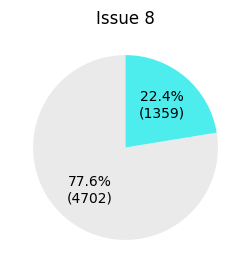

In [93]:
condition = (df['Issue_8'] == "TRUE")
title = "Issue 8"

visualize(condition, title)


# Issue 1 = 20.1%
# Issue 8 = 22.4%
# Issue 16= 18.8%


#Issue 8 and 16 has a bigger pick in 2023 then an evven bigger one in 2024
#issue that peaks in 2023 (relatively to the total volume of statements in the corpus)



# Render the visualizations

## 1. Timeline in absolute values, with context

PROs: Compares the query to the total. Comparable scales across different queries.

CONs: If the data volume is low, the pattern is too small to be visible, which also makes the small bars (low-volume months) impossible to analyze.

Figure saved as 'Timeline 1.png'.


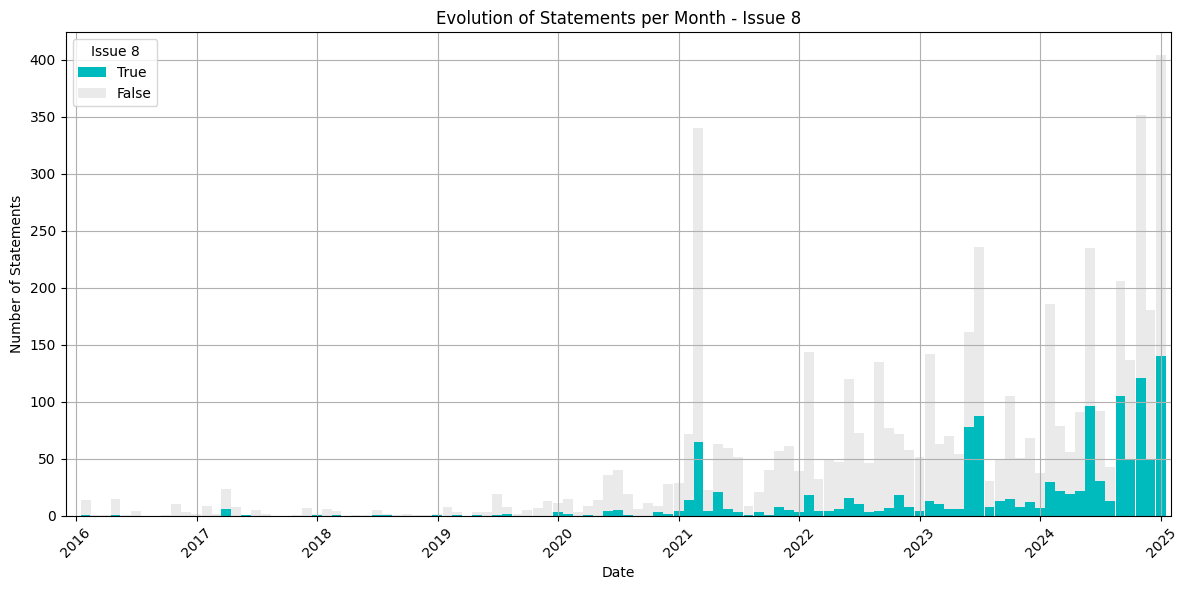

In [94]:
# Duplicate df into df_
df_ = df.copy()

# Mark each row of df_copy as filtered if the condition is fulfilled
df_['filtered'] = condition

# Remove rows where Year is out of range
df_ = df_[df_['Year'] >= settings['year_first']]
df_ = df_[df_['Year'] <= settings['year_last']]

# Convert 'Date of publication' to datetime
df_['Date of publication'] = pd.to_datetime(df_['Date of publication'], format='%Y-%m-%d', errors='coerce')

# Drop rows with invalid dates (NaT) resulting from the coercion
df_ = df_.dropna(subset=['Date of publication'])

# Group by month and filter status, then count statements
monthly_statements = df_.groupby([pd.Grouper(key='Date of publication', freq='ME'), 'filtered'])['filtered'].count().unstack(fill_value=0)

# Create the bar chart
plt.figure(figsize=(settings['plot_width'], settings['plot_height']))

# Set the x-axis limits
plt.xlim(pd.to_datetime(f'{settings["year_first"]-1}-12-01'), pd.to_datetime(f'{settings["year_last"]+1}-01-31'))

try: plt.bar(monthly_statements.index, monthly_statements[True], width=30, color='#00bbbd', label='True')
except: pass

try: plt.bar(monthly_statements.index, monthly_statements[False], width=30, bottom=monthly_statements[True], color='#EAEAEA', label='False')
except: pass

plt.xlabel('Date')
plt.ylabel('Number of Statements')
plt.title('Evolution of Statements per Month - '+title)
plt.grid(True)
plt.xticks(rotation=45)
plt.legend(title=title) # Display legend
plt.tight_layout()

# Save in 300dpi
filename = 'Timeline 1.png'
plt.savefig(filename, dpi=300)
print(f"Figure saved as '{filename}'.")

plt.show()

## 2. Timeline in absolute values, no context

Same as above, except without the grey bars.

PROs: Readable even when the general volume is low.

CONs: We can't compare to the total. We can't compare multiple queries, as they will have different scalings. The low-volume categories remain impossible to analyze.

Figure saved as 'Timeline 2.png'.


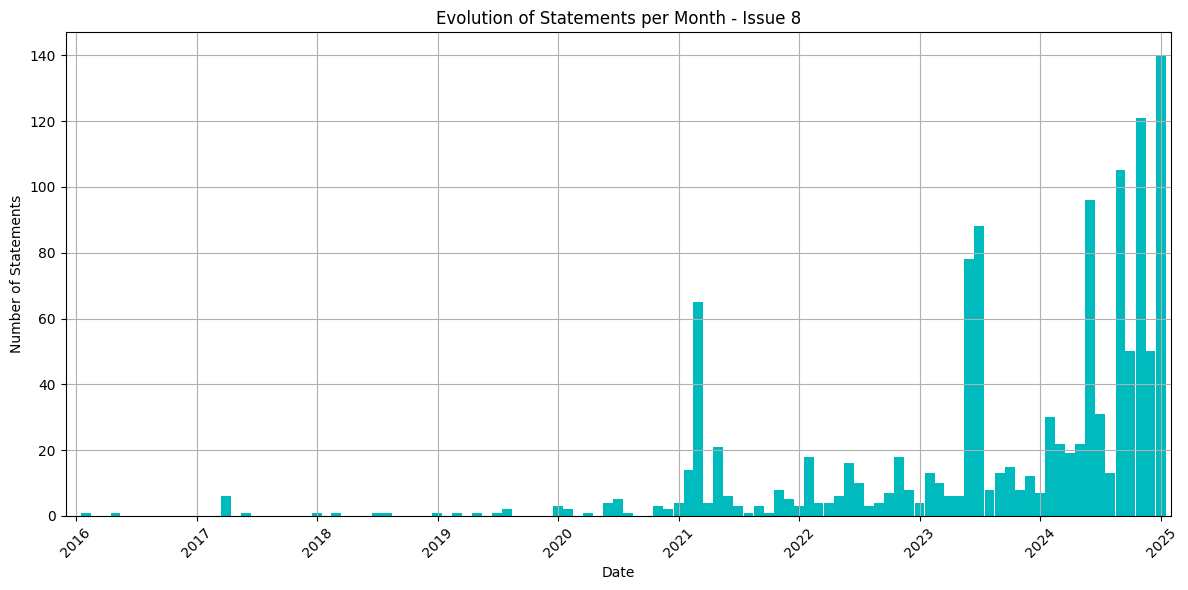

In [57]:
# Duplicate df into df_
df_ = df.copy()

# Mark each row of df_copy as filtered if the condition is fulfilled
df_['filtered'] = condition

# Remove rows where Year is out of range
df_ = df_[df_['Year'] >= settings['year_first']]
df_ = df_[df_['Year'] <= settings['year_last']]

# Convert 'Date of publication' to datetime
df_['Date of publication'] = pd.to_datetime(df_['Date of publication'], format='%Y-%m-%d', errors='coerce')

# Drop rows with invalid dates (NaT) resulting from the coercion
df_ = df_.dropna(subset=['Date of publication'])

# Group by month and filter status, then count statements
monthly_statements = df_.groupby([pd.Grouper(key='Date of publication', freq='ME'), 'filtered'])['filtered'].count().unstack(fill_value=0)

# Create the bar chart
plt.figure(figsize=(settings['plot_width'], settings['plot_height']))

# Set the x-axis limits
plt.xlim(pd.to_datetime(f'{settings["year_first"]-1}-12-01'), pd.to_datetime(f'{settings["year_last"]+1}-01-31'))

try: plt.bar(monthly_statements.index, monthly_statements[True], width=30, color='#00bbbd', label='True')
except: pass

plt.xlabel('Date')
plt.ylabel('Number of Statements')
plt.title('Evolution of Statements per Month - '+title)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Save in 300dpi
filename = 'Timeline 2.png'
plt.savefig(filename, dpi=300)
print(f"Figure saved as '{filename}'.")

plt.show()

## 3. Timeline in percentages, with context

Instead of the absolute values, we plot the percentage of statements.

PROs: The percentage makes more sense in more situations, because it takes the context (total volume) into account. Compares the query to the total.

CONs: If the query is low-volume it may not be readable. Months with very low volume get overrepresented.

Figure saved as 'Timeline 3.png'.


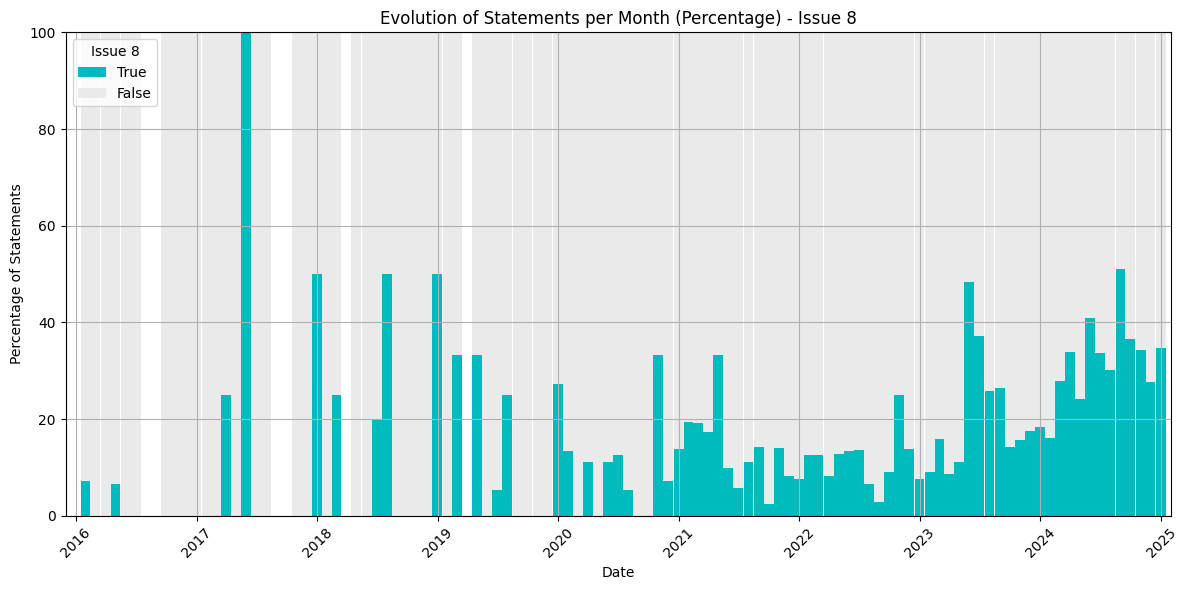

In [58]:
# Duplicate df into df_
df_ = df.copy()

# Mark each row of df_copy as filtered if the condition is fulfilled
df_['filtered'] = condition

# Remove rows where Year is out of range
df_ = df_[df_['Year'] >= settings['year_first']]
df_ = df_[df_['Year'] <= settings['year_last']]

# Convert 'Date of publication' to datetime
df_['Date of publication'] = pd.to_datetime(df_['Date of publication'], format='%Y-%m-%d', errors='coerce')

# Drop rows with invalid dates (NaT) resulting from the coercion
df_ = df_.dropna(subset=['Date of publication'])

# Group by month and filter status, then count statements
monthly_statements = df_.groupby([pd.Grouper(key='Date of publication', freq='ME'), 'filtered'])['filtered'].count().unstack(fill_value=0)

# Calculate percentages
monthly_statements_percentage = monthly_statements.div(monthly_statements.sum(axis=1), axis=0) * 100

# Create the bar chart
plt.figure(figsize=(settings['plot_width'], settings['plot_height']))

# Set the x-axis limits
plt.xlim(pd.to_datetime(f'{settings["year_first"]-1}-12-01'), pd.to_datetime(f'{settings["year_last"]+1}-01-31'))

try:
    plt.bar(monthly_statements_percentage.index, monthly_statements_percentage[True], width=30, color='#00BBBD', label='True')
    plt.bar(monthly_statements_percentage.index, monthly_statements_percentage[False], width=30, bottom=monthly_statements_percentage[True], color='#EAEAEA', label='False')
except:
    pass

plt.xlabel('Date')
plt.ylabel('Percentage of Statements')
plt.title('Evolution of Statements per Month (Percentage) - '+title)
plt.grid(True)
plt.xticks(rotation=45)
plt.legend(title=title) # Display legend
plt.tight_layout()

# Save in 300dpi
filename = 'Timeline 3.png'
plt.savefig(filename, dpi=300)
print(f"Figure saved as '{filename}'.")

plt.show()

## 4. Timeline in percentages, no context

Same as above but we adapt the Y scale.

PROs: The percentage makes more sense in more situations. Always readable.

CONs: Categories with very low volume get overrepresented.

Figure saved as 'Timeline 4.png'.


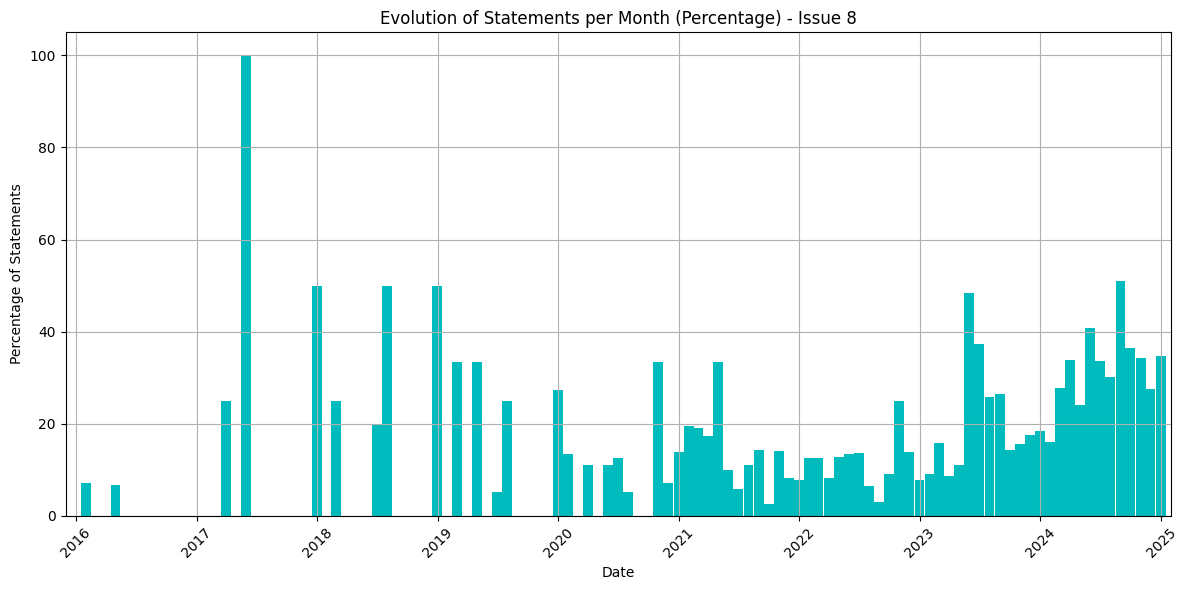

In [59]:
# Duplicate df into df_
df_ = df.copy()

# Mark each row of df_copy as filtered if the condition is fulfilled
df_['filtered'] = condition

# Remove rows where Year is out of range
df_ = df_[df_['Year'] >= settings['year_first']]
df_ = df_[df_['Year'] <= settings['year_last']]

# Convert 'Date of publication' to datetime
df_['Date of publication'] = pd.to_datetime(df_['Date of publication'], format='%Y-%m-%d', errors='coerce')

# Drop rows with invalid dates (NaT) resulting from the coercion
df_ = df_.dropna(subset=['Date of publication'])

# Group by month and filter status, then count statements
monthly_statements = df_.groupby([pd.Grouper(key='Date of publication', freq='ME'), 'filtered'])['filtered'].count().unstack(fill_value=0)

# Calculate percentages
monthly_statements_percentage = monthly_statements.div(monthly_statements.sum(axis=1), axis=0) * 100

# Create the bar chart
plt.figure(figsize=(settings['plot_width'], settings['plot_height']))

# Set the x-axis limits
plt.xlim(pd.to_datetime(f'{settings["year_first"]-1}-12-01'), pd.to_datetime(f'{settings["year_last"]+1}-01-31'))

try:
    plt.bar(monthly_statements_percentage.index, monthly_statements_percentage[True], width=30, color='#00BBBD', label='True')
except:
    pass

plt.xlabel('Date')
plt.ylabel('Percentage of Statements')
plt.title('Evolution of Statements per Month (Percentage) - '+title)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Save in 300dpi
filename = 'Timeline 4.png'
plt.savefig(filename, dpi=300)
print(f"Figure saved as '{filename}'.")

plt.show()